# Data Science - ICARO
_________________________________
Clase: 22

Tema: Proyecto integrador - No Supervisado
_________________________________


## Objetivo:
- Aplicar algoritmos de Clustering (KMeans, DBSCAN) para descubrir agrupaciones naturales en el dataset "Wine Quality".
- Utilizar técnicas de Reducción de Dimensionalidad (PCA, t-SNE, UMAP) para visualizar la estructura de los datos y los clusters.
- Interpretar los resultados de los métodos no supervisados y las visualizaciones, extrayendo conclusiones sobre la organización intrínseca de los datos de vino.

---

## Índice

1. [Imports y Configuración Inicial](#imports)
2. [Carga y Preparación de Datos](#carga)
3. [Análisis Exploratorio de Datos (EDA)](#eda)
4. [**Tarea 1: Clustering (Descubrir Grupos de Vino)**](#clustering)
    - 4.1. [Preparación de Datos para Clustering](#prep_clustering)
    - 4.2. [Modelo de Clustering 1: KMeans](#kmeans)
    - 4.3. [Modelo de Clustering 2: DBSCAN](#dbscan)
    - 4.4. [**(A COMPLETAR) Tareas Finales de Clustering y Conclusión**](#conclusion_clustering)
5. [**Tarea 2: Reducción de Dimensionalidad y Visualización**](#reduccion_dim)
    - 5.1. [Preparación de Datos para Reducción de Dimensionalidad](#prep_reduccion)
    - 5.2. [Técnica de Reducción 1: PCA para Visualización](#pca)
    - 5.3. [Técnica de Reducción 2: t-SNE para Visualización](#tsne)
    - 5.4. [Técnica de Reducción 3: UMAP para Visualización](#umap)
    - 5.5. [**(A COMPLETAR) Tareas Finales de Reducción y Conclusión**](#conclusion_reduccion)
6. [**(A COMPLETAR) Conclusiones Finales del Proyecto**](#final)

---


<a name="imports"></a>
# 1. Imports y Configuración Inicial
En esta primera celda, importaremos todas las librerías que necesitaremos para nuestro análisis de modelos no supervisados.

In [1]:
pip install umap-learn

In [2]:
# Manipulación de datos
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Modelos y Preprocesamiento
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap # Asegúrate de tener instalado 'umap-learn': pip install umap-learn

# Métricas de evaluación para clustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors

# Configuración de visualización
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['legend.fontsize'] = 10


<a name="carga"></a>
## 2. Carga y Preparación de Datos
Vamos a cargar los dos datasets (vino tinto y vino blanco), añadiremos una columna para identificar el tipo de vino y luego los uniremos en un único DataFrame.

In [3]:
# URLs de los datasets
url_red = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
url_white = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv'

# Carga de los dataframes
df_red = pd.read_csv(url_red, sep=';')
df_white = pd.read_csv(url_white, sep=';')

# Creación de la columna 'wine_type' (0 para tinto, 1 para blanco)
df_red['wine_type'] = 0
df_white['wine_type'] = 1

# Unión de los dataframes
df = pd.concat([df_red, df_white], axis=0)

# Reseteamos el índice
df.reset_index(drop=True, inplace=True)

print("Forma del dataset combinado:", df.shape)
print("\nPrimeras 5 filas:")
display(df.head())

Forma del dataset combinado: (6497, 13)

Primeras 5 filas:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0


se unifican los datasets de vino tinto y blanco. Se crea wine_type como variable auxiliar (0=tinto, 1=blanco) para interpretación posterior; el clustering se realiza sobre variables fisicoquímicas escaladas

In [4]:
# Verificación rápida de balance entre tipos de vino
df["wine_type"].value_counts()


,count
wine_type,
1,4898
0,1599


El dataset combinado contiene 6.497 registros y la variable auxiliar wine_type indica el tipo de vino: 0 = tinto y 1 = blanco.
**La distribución observada es:**
- wine_type = 1 (blanco): 4.898 observaciones
- wine_type = 0 (tinto): 1.599 observaciones

Esto muestra un desbalance por tipo de vino (predominan los blancos). Esta etiqueta se utilizará solo con fines descriptivos e interpretativos (por ejemplo, para analizar cómo se distribuyen los clusters según el tipo), mientras que el clustering se realizará sobre las variables fisicoquímicas escaladas.

<a name="eda"></a>
## 3. Análisis Exploratorio de Datos (EDA)
Antes de modelar, es crucial entender y preparar nuestros datos. Reutilizaremos el EDA básico del Módulo 2.

Información general del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  wine_type             6497 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 660.0 KB

Estadísticas descriptivas de las variab

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378,0.753886
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255,0.430779
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000,0.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000,1.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000,1.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000,1.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000,1.000000



Valores nulos por columna:
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
wine_type               0
dtype: int64


/tmp/ipython-input-2903907362.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='quality', data=df, palette='viridis')


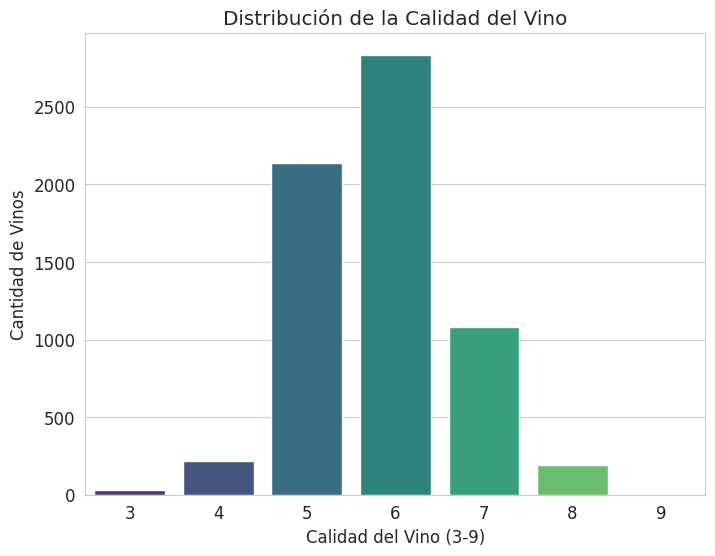

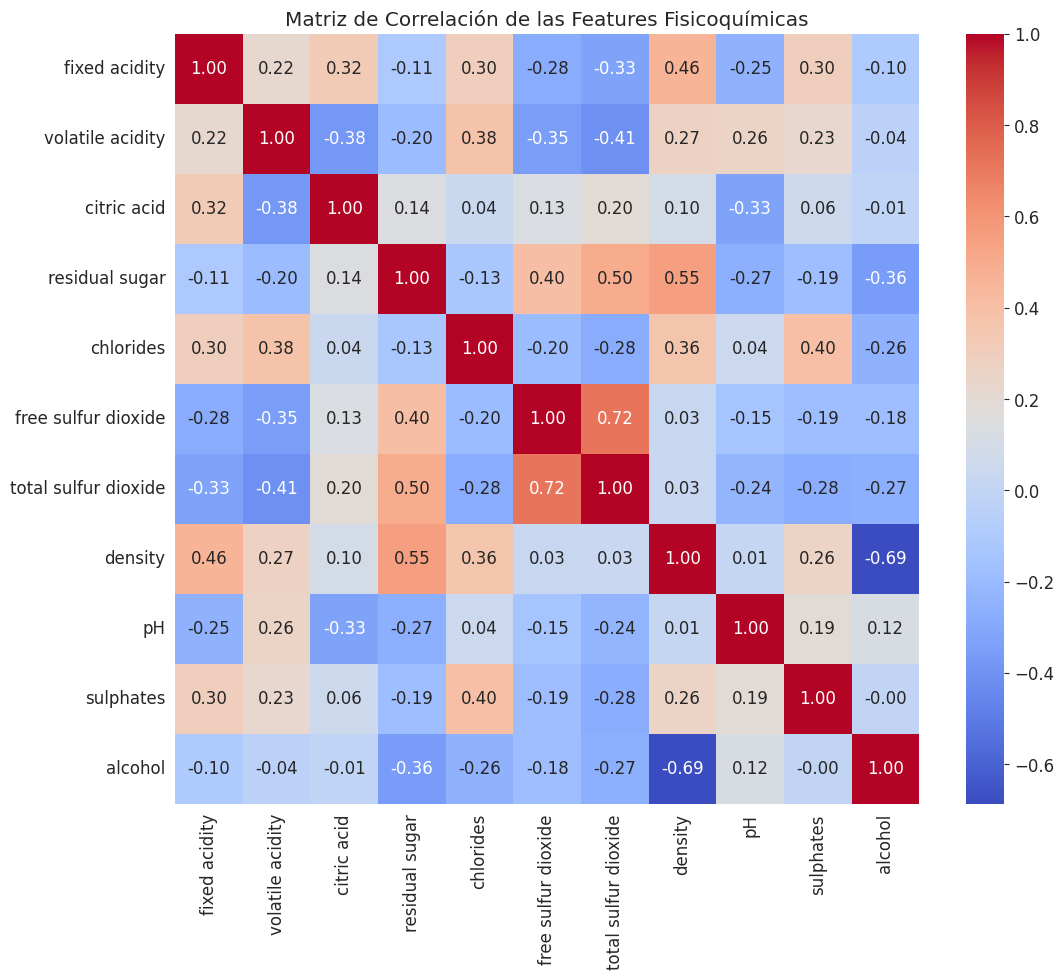

In [5]:
print("Información general del DataFrame:")
df.info()

print("\nEstadísticas descriptivas de las variables numéricas:")
display(df.describe())

print("\nValores nulos por columna:")
print(df.isnull().sum())

plt.figure(figsize=(8, 6))
sns.countplot(x='quality', data=df, palette='viridis')
plt.title('Distribución de la Calidad del Vino')
plt.xlabel('Calidad del Vino (3-9)')
plt.ylabel('Cantidad de Vinos')
plt.show()

# Matriz de correlación de las variables fisicoquímicas
plt.figure(figsize=(12, 10))
# Excluimos las columnas 'wine_type' y 'quality' para la matriz de correlación de features
correlation_matrix = df.drop(['wine_type', 'quality'], axis=1).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación de las Features Fisicoquímicas')
plt.show()


**Calidad y estructura del dataset**

El DataFrame resultante contiene 6.497 observaciones y 13 variables:

- 11 variables fisicoquímicas continuas (float64) que describen propiedades del vino.
- 2 variables enteras (int64): quality (calidad sensorial en escala discreta) y wine_type (0=tinto, 1=blanco), utilizada como etiqueta auxiliar para interpretación.



### (A COMPLETAR) Análisis del EDA
Basado en los resultados anteriores, comenta tus observaciones sobre:
- La distribución de las variables.
- La presencia de valores nulos (si los hay).
- Las correlaciones entre las características. ¿Hay alguna que te llame la atención?

**1) Distribución de las variables**

Las variables fisicoquímicas muestran rangos y dispersión heterogéneos. Por ejemplo, residual sugar presenta una dispersión alta y valores máximos muy elevados (posibles valores extremos), mientras que density y pH varían en rangos más acotados. La variable quality (escala 3–9) se concentra principalmente en valores intermedios, con mayor frecuencia alrededor de 5 y 6, y muy pocos casos en los extremos (3, 4, 8, 9). Esto sugiere que la calidad está desbalanceada hacia valores medios, típico del dataset.

**2) Valores nulos**

No se observan valores faltantes en ninguna columna (todas las variables presentan 6.497 valores no nulos), por lo que no es necesario aplicar imputación.

**3) Correlaciones entre características**

La matriz de correlación evidencia relaciones interesantes:

- free sulfur dioxide y total sulfur dioxide muestran una correlación positiva alta.
- residual sugar presenta correlación positiva con density.
- density se correlaciona negativamente con alcohol.

Estas relaciones son relevantes porque pueden influir en la forma de los clusters: variables fuertemente correlacionadas pueden aportar información redundante y, por eso, complementaremos el análisis con técnicas de reducción de dimensionalidad (PCA/t-SNE/UMAP) para visualizar mejor la estructura subyacente.

Además, el dataset está desbalanceado por tipo de vino (predominan los blancos), lo cual se tendrá en cuenta al interpretar la composición de los clusters

<a name="clustering"></a>
# 4. Tarea 1: Clustering (Descubrir Grupos de Vino)
En esta sección, aplicaremos algoritmos de clustering para identificar agrupaciones naturales dentro de nuestro dataset de vinos, sin utilizar las etiquetas de `wine_type` o `quality`.

<a name="prep_clustering"></a>
### 4.1. Preparación de Datos para Clustering
Para el clustering, solo usaremos las características fisicoquímicas de los vinos, y es **crucial** que estén escaladas. Las etiquetas originales (`wine_type`, `quality`) las guardaremos para una posterior comparación y análisis.

In [6]:
# Definir X (features) y las etiquetas originales (y_type, y_quality) para comparación
X = df.drop(['wine_type', 'quality'], axis=1)
y_type = df['wine_type']
y_quality = df['quality']

print(f"Dimensiones de X para clustering: {X.shape}")

# Escalar las características (fundamental para algoritmos basados en distancia)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("\nPrimeras 5 filas de X escalado:")
print(pd.DataFrame(X_scaled, columns=X.columns).head())

Dimensiones de X para clustering: (6497, 11)

Primeras 5 filas de X escalado:
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0       0.142473          2.188833    -2.192833       -0.744778   0.569958   
1       0.451036          3.282235    -2.192833       -0.597640   1.197975   
2       0.451036          2.553300    -1.917553       -0.660699   1.026697   
3       3.073817         -0.362438     1.661085       -0.744778   0.541412   
4       0.142473          2.188833    -2.192833       -0.744778   0.569958   

   free sulfur dioxide  total sulfur dioxide   density        pH  sulphates  \
0            -1.100140             -1.446359  1.034993  1.813090   0.193097   
1            -0.311320             -0.862469  0.701486 -0.115073   0.999579   
2            -0.874763             -1.092486  0.768188  0.258120   0.797958   
3            -0.762074             -0.986324  1.101694 -0.363868   0.327510   
4            -1.100140             -1.446359  1.034993  1.

Se definió la matriz de entrada X utilizando únicamente las 11 variables fisicoquímicas. Se excluyeron quality y wine_type (guardadas como y_quality y y_type) porque se emplearán solo para interpretar la composición de los clusters y no para el entrenamiento no supervisado.

Dado que KMeans y DBSCAN se basan en distancias, se aplicó StandardScaler para estandarizar las features (X_scaled). La verificación muestra medias ~0 y desvíos ~1, confirmando que todas las variables quedaron en una escala comparable.

In [7]:
# Chequeo rápido del escalado (opcional)
print("Media (aprox 0):", np.round(X_scaled.mean(axis=0), 3))
print("Std (aprox 1):", np.round(X_scaled.std(axis=0), 3))


Media (aprox 0): [-0.  0.  0.  0.  0. -0. -0. -0.  0. -0.  0.]
Std (aprox 1): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


**Verificación del escalado:** las features estandarizadas presentan medias aproximadamente 0 y desvíos estándar aproximadamente 1, confirmando la correcta aplicación de StandardScaler.

<a name="kmeans"></a>
### 4.2. Modelo de Clustering 1: KMeans
KMeans es un algoritmo de clustering que busca dividir $N$ observaciones en $K$ clusters, donde cada observación pertenece al cluster con la media (centroide) más cercana. Es nuestro punto de partida para identificar grupos.

#### TAREAS EN EL NOTEBOOK:
1.  **Paso 1: Determinar K óptimo (Método del Codo).**
    * Iterar `K` desde 1 hasta 15 (o un rango similar).
    * Para cada `K`, entrenar un modelo `KMeans` con `X_scaled` y guardar la inercia.
    * Graficar la inercia vs. `K`.
    * Identificar el `K_elegido` donde la curva forma un "codo" y justificar su elección en un comentario markdown.

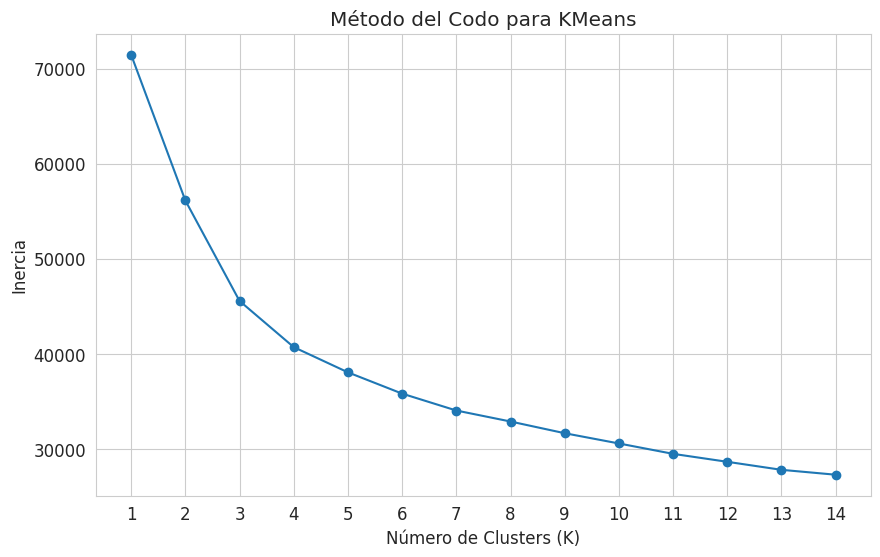

In [8]:
inertia = []
k_range = range(1, 15) # Probamos K desde 1 hasta 14

for k in k_range:
    # n_init='auto' es el valor por defecto para versiones recientes, o 10 para compatibilidad.
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.title('Método del Codo para KMeans')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Inercia')
plt.xticks(k_range)
plt.grid(True)
plt.show()

# (A COMPLETAR) Justifica tu elección de K aquí
# Por ejemplo: "Observando el gráfico del método del codo, el punto de inflexión más pronunciado parece estar en K = X. Por lo tanto, elegimos X clusters."
k_elegido = 4 # Reemplaza None con el valor de K que elegiste


Al analizar la curva Inercia vs K, se observa una disminución muy pronunciada de la inercia al pasar de K=1 a K=3, la caída fuerte ocurre hasta K=3–4 y a partir de allí la ganancia marginal disminuye, por lo que el ‘codo’ se ubica aproximadamente en K=4.

Por lo tanto, se elige K = 4 como un punto de compromiso entre:

- mejorar el ajuste (reducir la inercia) y
- mantener interpretabilidad (evitar demasiados clusters con ganancia pequeña).

2.  **Paso 2: Ejecutar KMeans.**
    * Inicializar y entrenar `KMeans` con `n_clusters=K_elegido` y `random_state=42`.
    * Obtener las asignaciones de cluster usando `.fit_predict(X_scaled)`. Guardar en la variable `clusters_kmeans`.
    * Mostrar la cuenta de puntos por cluster (usando `pd.Series(clusters_kmeans).value_counts()`).

Con el valor seleccionado de K (4), entrenamos el modelo KMeans final y obtenemos las etiquetas de cluster para cada observación.

In [9]:
if k_elegido is not None:
    kmeans_final = KMeans(n_clusters=k_elegido, random_state=42, n_init=10)
    clusters_kmeans = kmeans_final.fit_predict(X_scaled)

    print(f"Número de puntos por cluster (KMeans con K={k_elegido}):")
    print(pd.Series(clusters_kmeans).value_counts().sort_index())
else:
    print("Por favor, define 'k_elegido' en la celda anterior.")

Número de puntos por cluster (KMeans con K=4):
0    1006
1    1873
2     687
3    2931
Name: count, dtype: int64


**Distribución de observaciones por cluster (KMeans, K=4)**

Al entrenar KMeans con K=4, se obtuvieron los siguientes tamaños de cluster:
- Cluster 0: 1006 observaciones
- Cluster 1: 1873 observaciones
- Cluster 2: 687 observaciones
- Cluster 3: 2931 observaciones

Se observa una distribución desigual: el cluster 3 concentra la mayor proporción de registros, mientras que el cluster 2 es el más pequeño.

3.  **Paso 3: Evaluación de KMeans con Silhouette Score.**
    * Calcular y mostrar el `silhouette_score(X_scaled, clusters_kmeans)`.
    * Opcional: Calcular Calinski-Harabasz Score y Davies-Bouldin Score.

In [10]:
if 'clusters_kmeans' in locals():
    silhouette_avg_kmeans = silhouette_score(X_scaled, clusters_kmeans)
    print(f"Silhouette Score para KMeans (K={k_elegido}): {silhouette_avg_kmeans:.3f}")

    calinski_kmeans = calinski_harabasz_score(X_scaled, clusters_kmeans)
    davies_kmeans = davies_bouldin_score(X_scaled, clusters_kmeans)
    print(f"Calinski-Harabasz Score para KMeans: {calinski_kmeans:.3f}")
    print(f"Davies-Bouldin Score para KMeans: {davies_kmeans:.3f}")
else:
    print("Por favor, ejecuta las celdas anteriores para generar los clusters de KMeans.")

Silhouette Score para KMeans (K=4): 0.248
Calinski-Harabasz Score para KMeans: 1634.158
Davies-Bouldin Score para KMeans: 1.470


Se evaluó el resultado de KMeans con K=4 usando tres métricas internas:

- **Silhouette Score** = 0.248: indica una separación moderada/baja entre clusters. En general, valores cercanos a 1 implican clusters bien separados, alrededor de 0 implican solapamiento, y negativos sugieren mala asignación. Un valor de 0.248 sugiere que los grupos existen, pero no están fuertemente separados en el espacio de features estandarizadas.

- **Calinski–Harabasz** = 1634.158: esta métrica mayor es mejor y mide la relación entre la dispersión inter-cluster y la intra-cluster. El valor obtenido indica que existe cierta estructura de agrupamiento, pero debe compararse con otros K (por ejemplo K=3 y K=5) para justificar mejor la elección final.

- **Davies–Bouldin** = 1.470: en esta métrica menor es mejor (clusters más compactos y bien separados). Un valor de 1.470 sugiere que hay solapamiento entre algunos grupos y que la compactación/separación podría mejorar con otra elección de K o con otro algoritmo (por ejemplo DBSCAN) o reducción de dimensionalidad previa.

**Completar curvas de cada métrica**

,K,Silhouette,Calinski-Harabasz,Davies-Bouldin
0,2,0.276521,1772.646610,1.600351
2,4,0.247527,1634.158207,1.470252
1,3,0.235071,1844.457339,1.484034
4,6,0.186317,1291.124335,1.621966
3,5,0.180489,1423.849591,1.773171


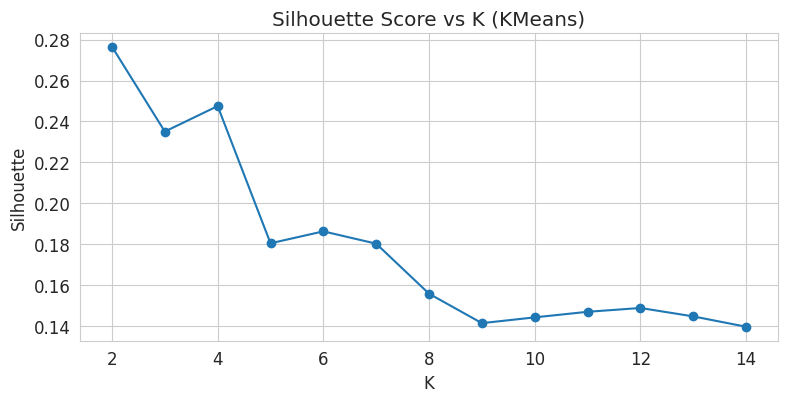

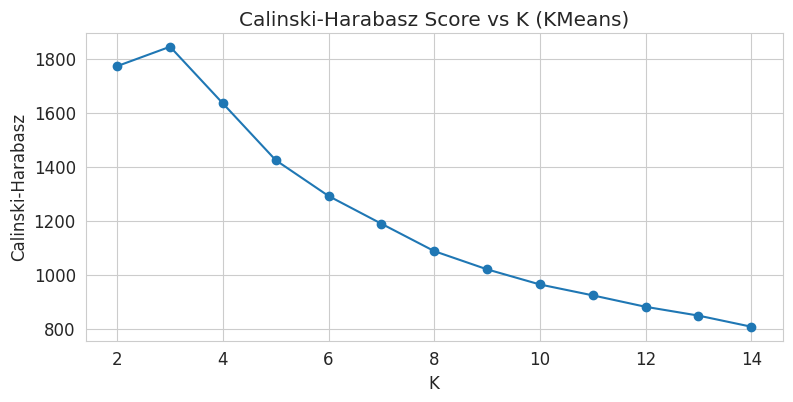

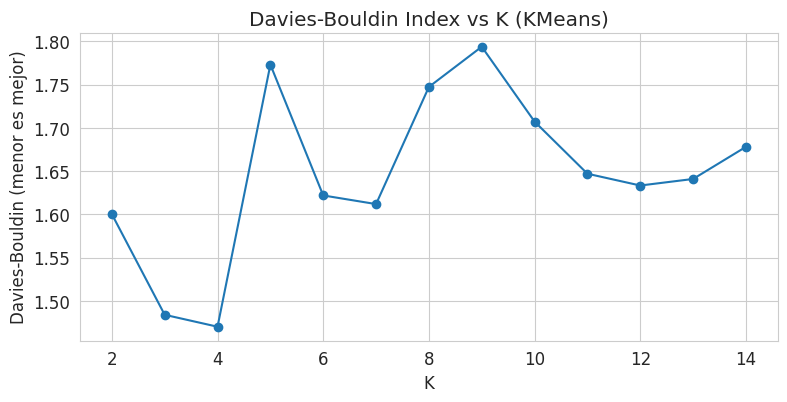

In [11]:
# --- Curvas de métricas para elegir K (KMeans) ---
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import pandas as pd
import matplotlib.pyplot as plt

k_values = range(2, 15)  # silhouette requiere al menos 2 clusters

sil_scores = []
ch_scores = []
db_scores = []

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)

    sil_scores.append(silhouette_score(X_scaled, labels))
    ch_scores.append(calinski_harabasz_score(X_scaled, labels))
    db_scores.append(davies_bouldin_score(X_scaled, labels))

# Tabla resumen (útil para justificar)
metrics_df = pd.DataFrame({
    "K": list(k_values),
    "Silhouette": sil_scores,
    "Calinski-Harabasz": ch_scores,
    "Davies-Bouldin": db_scores
})

display(metrics_df.sort_values("Silhouette", ascending=False).head(5))

# Curva Silhouette
plt.figure(figsize=(9, 4))
plt.plot(list(k_values), sil_scores, marker='o')
plt.title("Silhouette Score vs K (KMeans)")
plt.xlabel("K")
plt.ylabel("Silhouette")
plt.grid(True)
plt.show()

# Curva Calinski-Harabasz
plt.figure(figsize=(9, 4))
plt.plot(list(k_values), ch_scores, marker='o')
plt.title("Calinski-Harabasz Score vs K (KMeans)")
plt.xlabel("K")
plt.ylabel("Calinski-Harabasz")
plt.grid(True)
plt.show()

# Curva Davies-Bouldin
plt.figure(figsize=(9, 4))
plt.plot(list(k_values), db_scores, marker='o')
plt.title("Davies-Bouldin Index vs K (KMeans)")
plt.xlabel("K")
plt.ylabel("Davies-Bouldin (menor es mejor)")
plt.grid(True)
plt.show()


Selección de K (KMeans) basada en métricas internas y método del codo
Se evaluaron valores de K = 2 a 14 utilizando Silhouette, Calinski–Harabasz y Davies–Bouldin, junto con el método del codo (inercia):

- **Silhouette** alcanza su máximo en K=2 (~0.277), lo que sugiere la mejor separación promedio para dos grupos; sin embargo, esta partición puede resultar demasiado general para capturar subestructuras del dataset.

- **Calinski–Harabasz** presenta su mejor valor en K=3 (~1844), indicando una relación favorable entre separación entre clusters y compactación interna.

- **Davies–Bouldin** (menor es mejor) obtiene su mejor valor en K=4 (~1.470), sugiriendo clusters relativamente más compactos y mejor separados frente a K cercanos.

- El método del codo muestra un punto de inflexión alrededor de K=3–4, y luego las mejoras en inercia se vuelven marginales.

**En conjunto, se selecciona K=4 como un compromiso entre:**

- capturar mayor granularidad que K=2,
- mantener interpretabilidad, y
- favorecer la compacidad/separación reflejada por Davies–Bouldin, coherente con el codo observado.

<a name="dbscan"></a>
### 4.3. Modelo de Clustering 2: DBSCAN
DBSCAN (Density-Based Spatial Clustering of Applications with Noise) es un algoritmo basado en densidad que agrupa puntos que están densamente conectados, marcando como ruido los puntos que se encuentran en regiones de baja densidad.

#### TAREAS EN EL NOTEBOOK:
1.  **Paso 1: Determinar `eps` y `min_samples` óptimos.**
    * Establecer un `min_samples` inicial (ej., `2 * numero_de_features` o 5).
    * Calcular las distancias al `min_samples`-ésimo vecino más cercano para cada punto.
    * Graficar estas distancias ordenadas.
    * Identificar el "codo" en el gráfico para estimar un `eps_elegido` y justificarlo en un comentario markdown.

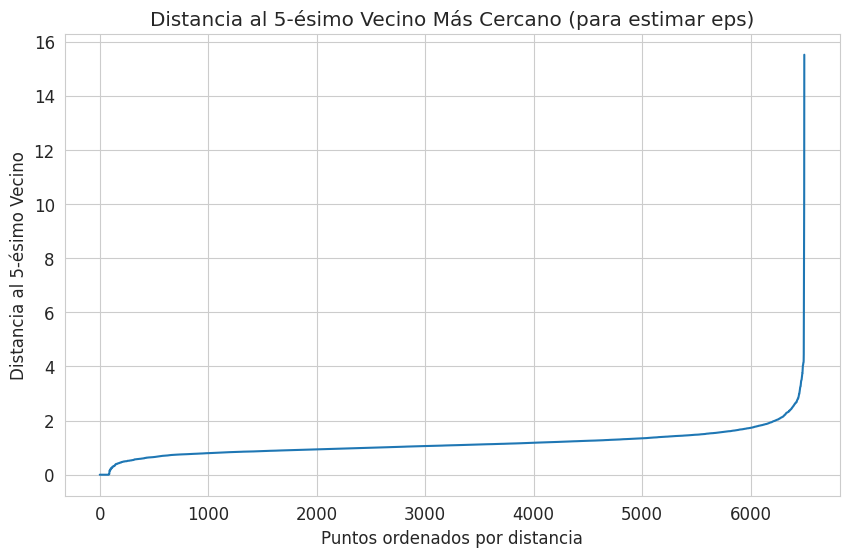

In [12]:
# Para min_samples, un valor común es 2 * número_de_dimensiones, o simplemente 5.
# Para este dataset de vinos (11 dimensiones), probamos min_samples=5 como valor inicial estándar y luego comparamos con valores mayores.
min_samples_dbscan = 5 # Experimenta con otros valores, ej. 5

# Encontrar las distancias al k-ésimo vecino más cercano
neighbors = NearestNeighbors(n_neighbors=min_samples_dbscan)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

# Ordenar las distancias del k-ésimo vecino
distances = np.sort(distances[:, min_samples_dbscan-1], axis=0) # Indexamos min_samples-1 porque es el k-ésimo vecino

plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title(f'Distancia al {min_samples_dbscan}-ésimo Vecino Más Cercano (para estimar eps)')
plt.xlabel('Puntos ordenados por distancia')
plt.ylabel(f'Distancia al {min_samples_dbscan}-ésimo Vecino')
plt.grid(True)
plt.show()

# (A COMPLETAR) Justifica tu elección de eps aquí
# Por ejemplo: "Observando el gráfico de distancias, el 'codo' más pronunciado parece estar alrededor de eps = Y. Por lo tanto, elegimos Y."
eps_elegido = 2.0 # Reemplaza None con el valor de eps que elegiste


En el gráfico de distancias al 5° vecino se observa un cambio brusco de pendiente alrededor de eps ≈ 2.0. Hasta ese valor las distancias aumentan gradualmente (zonas densas); a partir de allí crecen rápidamente (puntos aislados / potencial ruido). Por ello se selecciona eps=2.0 como umbral inicial

2.  **Paso 2: Ejecutar DBSCAN.**
    * Inicializar y entrenar `DBSCAN` con `eps=eps_elegido` y `min_samples=min_samples_dbscan`.
    * Obtener las asignaciones de cluster usando `.fit_predict(X_scaled)`. Guardar en `clusters_dbscan`.
    * Mostrar la cuenta de puntos por cluster, destacando el cluster `-1` (ruido).

In [13]:
if eps_elegido is not None:
    dbscan_final = DBSCAN(eps=eps_elegido, min_samples=min_samples_dbscan)
    clusters_dbscan = dbscan_final.fit_predict(X_scaled)

    print(f"Número de puntos por cluster (DBSCAN con eps={eps_elegido}, min_samples={min_samples_dbscan}):")
    print(pd.Series(clusters_dbscan).value_counts().sort_index())
else:
    print("Por favor, define 'eps_elegido' en la celda anterior.")

Número de puntos por cluster (DBSCAN con eps=2.0, min_samples=5):
-1     149
 0    6317
 1       7
 2      11
 3       6
 4       7
Name: count, dtype: int64


3.  **Paso 3: Evaluación de DBSCAN con Silhouette Score (excluyendo ruido).**
    * Calcular y mostrar el `silhouette_score` para DBSCAN, **excluyendo los puntos clasificados como ruido** (`clusters_dbscan != -1`).
    * Opcional: Calcular Calinski-Harabasz Score y Davies-Bouldin Score (excluyendo ruido).

In [14]:
if 'clusters_dbscan' in locals():
    valid_indices = clusters_dbscan != -1
    if np.unique(clusters_dbscan[valid_indices]).size > 1: # Asegurarse de que haya al menos 2 clusters válidos
        silhouette_avg_dbscan = silhouette_score(X_scaled[valid_indices], clusters_dbscan[valid_indices])
        print(f"Silhouette Score para DBSCAN (excluyendo ruido): {silhouette_avg_dbscan:.3f}")

        calinski_dbscan = calinski_harabasz_score(X_scaled[valid_indices], clusters_dbscan[valid_indices])
        davies_dbscan = davies_bouldin_score(X_scaled[valid_indices], clusters_dbscan[valid_indices])
        print(f"Calinski-Harabasz Score para DBSCAN: {calinski_dbscan:.3f}")
        print(f"Davies-Bouldin Score para DBSCAN: {davies_dbscan:.3f}")
    else:
        print("No hay suficientes clusters válidos (más de 1) en DBSCAN para calcular Silhouette Score.")
else:
    print("Por favor, ejecuta las celdas anteriores para generar los clusters de DBSCAN.")

Silhouette Score para DBSCAN (excluyendo ruido): 0.212
Calinski-Harabasz Score para DBSCAN: 53.781
Davies-Bouldin Score para DBSCAN: 0.763


**Selección de parámetros (DBSCAN)**

Se probaron distintas combinaciones de min_samples y eps. Con min_samples=22 el algoritmo resulta demasiado conservador: se obtiene un cluster dominante y un microcluster, con poca segmentación real. Con min_samples=10 y eps=1.6 aumenta el ruido y se obtienen métricas internas débiles (Silhouette muy bajo), por lo que se descarta.

La mejor configuración fue min_samples=5 y eps=2.0, ya que produce una proporción baja de ruido (149 observaciones) y el mejor desempeño según Davies–Bouldin (0.763, menor es mejor), indicando clusters más compactos y relativamente mejor separados. El Silhouette (0.212) sigue siendo bajo-moderado, lo que sugiere solapamiento entre grupos.

**Resultado e interpretación**

Con min_samples=5 y eps=2.0 DBSCAN identifica un cluster principal que agrupa la gran mayoría de observaciones y varios clusters muy pequeños. Esto indica que el dataset no presenta múltiples regiones densas grandes claramente separadas; DBSCAN funciona aquí principalmente como un método para detectar pequeños subgrupos densos y algunos outliers, más que como una segmentación equilibrada del conjunto.

| Modelo | Parámetros              | #clusters (sin ruido) |      Ruido | Silhouette* | Davies-Bouldin* |
| ------ | ----------------------- | --------------------: | ---------: | ----------: | --------------: |
| KMeans | K=4                     |                     4 |         0% |       0.248 |           1.470 |
| DBSCAN | eps=2.0, min_samples=5  |                     5 | 149 (2.3%) |       0.212 |           0.763 |
| DBSCAN | eps=2.0, min_samples=22 |                     2 | 294 (4.5%) |       0.205 |           1.040 |


*métricas calculadas excluyendo ruido para DBSCAN*

Se selecciona DBSCAN (eps=2.0, min_samples=5) como mejor configuración dentro de DBSCAN. En comparación global, KMeans produce una segmentación más equilibrada, mientras DBSCAN detecta un cluster dominante y subgrupos densos pequeños, con mejor compactación (DB menor).

<a name="conclusion_clustering"></a>
### 4.4. (A COMPLETAR) Tareas Finales de Clustering y Conclusión
No basta con aplicar los algoritmos; es crucial entender qué nos dicen los clusters y cuál enfoque es más adecuado para nuestro dataset de vinos.

#### TAREAS EN EL NOTEBOOK:
1.  **Métricas Clave:**
    * Recopilen los `Silhouette Score` de KMeans y DBSCAN. ¿Cuál algoritmo obtuvo un mejor score y qué implica en términos de cohesión y separación de clusters?

In [15]:
print("\n--- Comparación de Métricas de Clustering ---")
if 'silhouette_avg_kmeans' in locals():
    print(f"KMeans (K={k_elegido}): Silhouette Score = {silhouette_avg_kmeans:.3f}")
if 'silhouette_avg_dbscan' in locals():
    print(f"DBSCAN (eps={eps_elegido}, min_samples={min_samples_dbscan}): Silhouette Score = {silhouette_avg_dbscan:.3f}")

# (A COMPLETAR) Compara y comenta los scores aquí:
# "Basado en el Silhouette Score, [KMeans/DBSCAN] parece generar clusters con mejor separación y cohesión interna debido a..."


--- Comparación de Métricas de Clustering ---
KMeans (K=4): Silhouette Score = 0.248
DBSCAN (eps=2.0, min_samples=5): Silhouette Score = 0.212


En términos de cohesión y separación promedio, **KMeans obtiene un Silhouette ligeramente superior**, por lo que entrega una partición global más consistente para este dataset. No obstante, ambos valores son bajos a moderados, lo que sugiere **solapamiento** entre grupos y ausencia de fronteras muy nítidas en el espacio de variables fisicoquímicas.



2.  **Análisis de Clusters vs. Etiquetas Originales:**
    * Para el clustering que consideren "mejor" o más interesante, analicen la distribución de las etiquetas `y_type` (tipo de vino: tinto/blanco) y `y_quality` (calidad del vino) dentro de cada cluster.
    * Pueden usar `pd.crosstab()` o gráficos de barras/conteo para visualizar esto.
    * ¿Hay algún cluster que sea predominantemente de un tipo de vino o de una calidad particular?

In [16]:
# (A COMPLETAR) Elige el conjunto de clusters que consideres más interesante (ej. clusters_kmeans o clusters_dbscan)
clusters_para_analisis = clusters_kmeans # O clusters_dbscan

if 'clusters_para_analisis' in locals():
    # Análisis de clusters vs. Tipo de Vino
    print("\n--- Análisis de Clusters vs. Tipo de Vino Original ---")
    crosstab_type = pd.crosstab(clusters_para_analisis, y_type)
    display(crosstab_type)

    # Análisis de clusters vs. Calidad del Vino
    print("\n--- Análisis de Clusters vs. Calidad del Vino Original ---")
    crosstab_quality = pd.crosstab(clusters_para_analisis, y_quality)
    display(crosstab_quality)

    # (A COMPLETAR) Comenta tus observaciones sobre estos cruces:
    # "Observamos que el cluster X tiene una alta proporción de vinos [tintos/blancos]..."
    # "En cuanto a la calidad, el cluster Y parece agrupar vinos de [alta/baja/media] calidad..."
else:
    print("Por favor, asegúrate de que 'clusters_kmeans' o 'clusters_dbscan' estén definidos.")


--- Análisis de Clusters vs. Tipo de Vino Original ---


wine_type,0,1
row_0,,
0,917,89
1,4,1869
2,638,49
3,40,2891



--- Análisis de Clusters vs. Calidad del Vino Original ---


quality,3,4,5,6,7,8,9
row_0,,,,,,,
0,7,71,503,366,53,6,0
1,10,44,797,833,157,31,1
2,5,20,229,285,136,12,0
3,8,81,609,1352,733,144,4


**Clusters vs wine_type (KMeans, K=4):**

- Se observa una separación muy marcada por tipo de vino.

- El cluster 1 y el cluster 3 están compuestos casi totalmente por el tipo 1 (predominancia muy alta).

- El cluster 0 y el cluster 2 están compuestos mayormente por el tipo 0.
Esto sugiere que las variables fisicoquímicas capturan diferencias estructurales claras entre tipos de vino, y KMeans logra reflejar esa estructura.

**Clusters vs quality:**

- La calidad aparece más solapada entre clusters (no hay un cluster “puro” por calidad).

- Aun así, se aprecian tendencias: por ejemplo, algunos clusters concentran relativamente más vinos de calidad 6–7, mientras que otros tienen mayor peso en calidades 5–6.

Conclusión: el clustering separa mejor por tipo de vino que por calidad, lo cual es esperable porque “quality” suele depender de combinaciones más sutiles de variables.

3.  **Completar la Tabla de Resultados de Clustering:**
    * Llenen la siguiente tabla resumen con los resultados de ambos algoritmos.

| Algoritmo | Parámetros Clave (K / eps, min_samples) | Nº Clusters Encontrados | Nº Outliers (DBSCAN) | Silhouette Score |
|-----------|-----------------------------------------|-------------------------|----------------------|------------------|
| KMeans    | `K = [4]`                            | `[4]`      | N/A                  | `[0.248]`     |
| DBSCAN    | `eps = [2.0], min_samples = [5]` | `[5 (clusters 0–4)]`      | `[149]`   | `[0.212]`     |

Nota: en DBSCAN el “ruido” corresponde a la etiqueta -1, por eso outliers = 149

4.  **Justificar:**
    * Escriban una conclusión clara: ¿Qué algoritmo de clustering (KMeans o DBSCAN) eligen como el más "revelador" o útil para este dataset y por qué?
    * Consideren la calidad de los clusters, la interpretabilidad de los resultados, la capacidad de manejar formas no esféricas y su capacidad para encontrar patrones significativos.

En este dataset, **KMeans (K=4)** resultó el método más "revelador" para segmentación general: genera grupos estables y comparables, y además se alinea con una separación clara por **tipo de vino**. **DBSCAN** aportó valor como método de **detección de ruido/outliers**, pero no produjo una partición global equilibrada (cluster dominante + microclusters).

**Conclusión (clustering):** Para este dataset, **KMeans (K=4)** resulta el enfoque más útil para segmentar globalmente los vinos, mientras que **DBSCAN** aporta valor principalmente como complemento para **detectar outliers** y subgrupos muy densos.

```
(A COMPLETAR) Mi Conclusión sobre el Mejor Algoritmo de Clustering:

Basado en [métricas de evaluación, análisis de clusters vs. etiquetas originales, y observaciones visuales], considero que el algoritmo [KMeans / DBSCAN] es el más adecuado para descubrir la estructura natural de este dataset de vinos porque...

```

Mi conclusión: En este dataset, KMeans (K=4) resulta el enfoque más útil para una segmentación global e interpretable. Presenta un Silhouette ligeramente superior (0.248) frente a DBSCAN (0.212, calculado excluyendo ruido), y produce clusters de tamaño razonable que permiten análisis comparativos claros.
DBSCAN, si bien muestra mejor Davies–Bouldin (mayor compactación relativa al excluir ruido), en la práctica genera un cluster dominante y varios microclusters, por lo que es menos informativo como partición principal. Su aporte más valioso aquí es detectar outliers y pequeños subgrupos densos.

Al cruzar con etiquetas originales, KMeans evidencia una separación muy marcada por wine_type, mientras que quality permanece más distribuida entre clusters. Por ello, se elige KMeans como método principal y DBSCAN como complemento para detección de anomalías.

<a name="reduccion_dim"></a>
# 5. Tarea 2: Reducción de Dimensionalidad y Visualización
Dado que nuestros datos tienen 11 características, es difícil visualizarlos. Aplicaremos técnicas de reducción de dimensionalidad para proyectar los datos a 2 dimensiones, permitiéndonos ver la estructura de los clusters encontrados.

<a name="prep_reduccion"></a>
### 5.1. Preparación de Datos para Reducción de Dimensionalidad
La entrada para las técnicas de reducción de dimensionalidad serán los datos escalados (`X_scaled`) que preparamos previamente.

In [17]:
print(f"Los datos de entrada para la reducción de dimensionalidad son X_scaled con forma: {X_scaled.shape}")


Los datos de entrada para la reducción de dimensionalidad son X_scaled con forma: (6497, 11)


Para las técnicas de reducción de dimensionalidad utilizamos X_scaled, que contiene las 11 variables fisicoquímicas estandarizadas. La forma (6497, 11) indica 6497 observaciones y 11 características.

<a name="pca"></a>
### 5.2. Técnica de Reducción 1: PCA para Visualización
PCA (Principal Component Analysis) es una técnica de reducción de dimensionalidad lineal que busca las direcciones (componentes principales) en los datos que maximizan la varianza.

#### TAREAS EN EL NOTEBOOK:
1.  **Paso 1: Aplicar PCA.**
    * Inicializar `PCA(n_components=2, random_state=42)`.
    * Entrenar y transformar `X_scaled` usando `.fit_transform()`. Guardar en `X_pca`.

In [18]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print(f"Forma de los datos después de PCA: {X_pca.shape}")

Forma de los datos después de PCA: (6497, 2)


Se aplicó PCA con n_components=2 para proyectar las 11 variables fisicoquímicas estandarizadas a dos componentes principales. El resultado X_pca tiene forma (6497, 2), por lo que cada observación queda representada en un plano 2D, facilitando la visualización de la estructura y la comparación de clusters

In [19]:
print("Varianza explicada por cada componente:", np.round(pca.explained_variance_ratio_, 4))
print("Varianza explicada acumulada:", np.round(pca.explained_variance_ratio_.sum(), 4))


Varianza explicada por cada componente: [0.2754 0.2267]
Varianza explicada acumulada: 0.5022


Los dos primeros componentes principales explican el 50.22% de la varianza total (PC1 = 27.54%, PC2 = 22.67%). Esto indica que la proyección 2D retiene aproximadamente la mitad de la información del espacio original (11 variables). Por lo tanto, el gráfico PCA es útil para visualizar tendencias generales y separaciones aproximadas, pero puede perder parte de la estructura existente en dimensiones restantes

2.  **Paso 2: Visualizar Clusters de KMeans en PCA.**
    * Crear un `scatter plot` de `X_pca` coloreado por `clusters_kmeans`.
    * Añadir título, etiquetas de ejes y una barra de color.

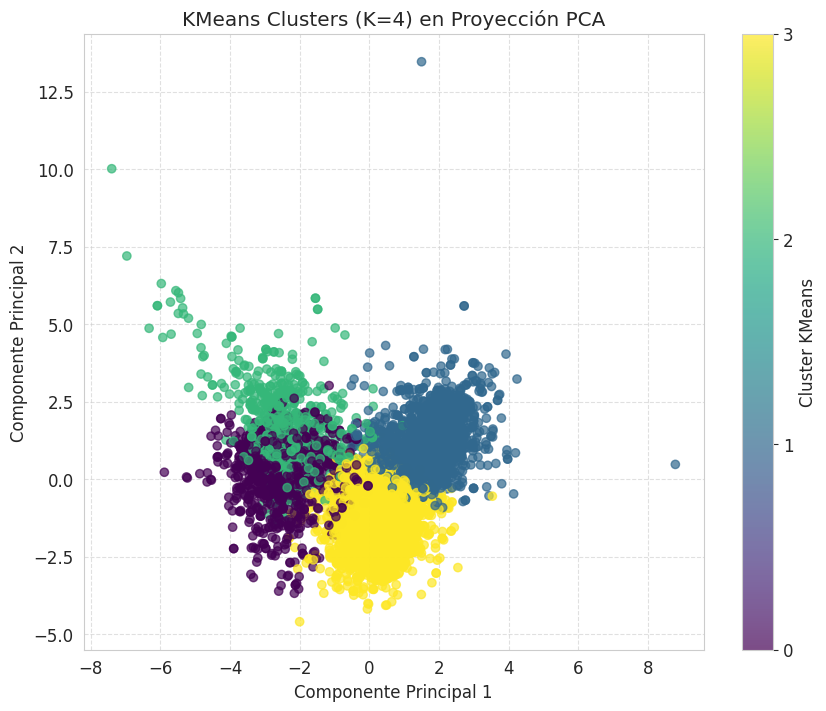

In [20]:
if 'clusters_kmeans' in locals():
    plt.figure(figsize=(10, 8))
    scatter_kmeans_pca = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters_kmeans, cmap='viridis', alpha=0.7)
    plt.title(f'KMeans Clusters (K={k_elegido}) en Proyección PCA')
    plt.xlabel('Componente Principal 1')
    plt.ylabel('Componente Principal 2')
    plt.colorbar(scatter_kmeans_pca, label='Cluster KMeans', ticks=range(k_elegido))
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()
else:
    print("Por favor, ejecuta la sección de KMeans para obtener 'clusters_kmeans'.")

**KMeans (K=4) en proyección PCA:**

En la proyección PCA se observan cuatro regiones que corresponden a los clusters de KMeans. Hay separación visual parcial entre grupos: algunos clusters aparecen relativamente compactos y distinguibles, mientras que otros muestran solapamiento en la zona central. Esta visualización es consistente con un Silhouette moderado/bajo (≈0.248): existen agrupamientos, pero no están fuertemente separados en el espacio.

3.  **Paso 3: Visualizar Clusters de DBSCAN en PCA.**
    * Crear un `scatter plot` de `X_pca` coloreado por `clusters_dbscan`.
    * Añadir título, etiquetas de ejes y una barra de color.

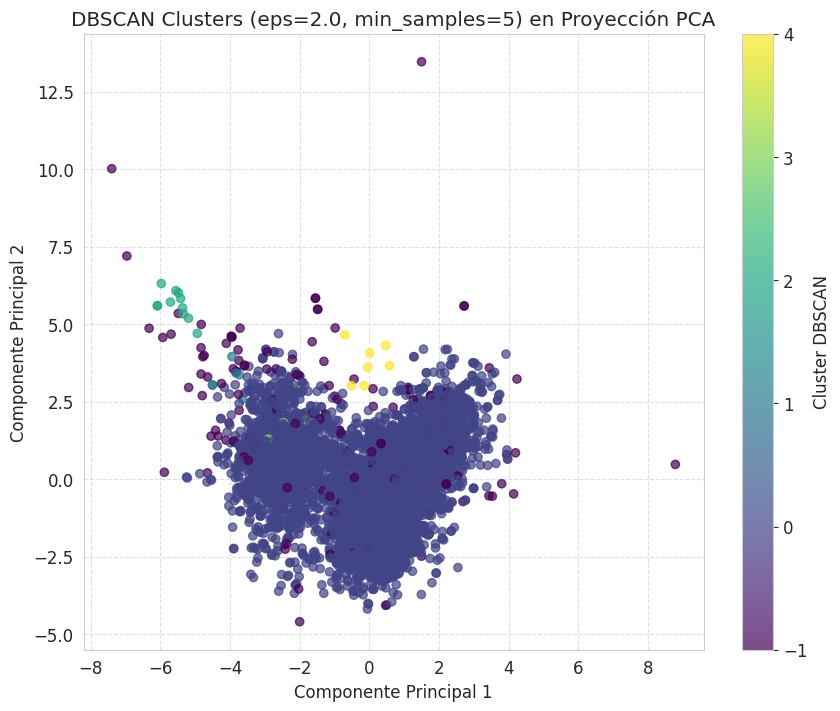

In [21]:
if 'clusters_dbscan' in locals():
    plt.figure(figsize=(10, 8))
    scatter_dbscan_pca = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters_dbscan, cmap='viridis', alpha=0.7)
    plt.title(f'DBSCAN Clusters (eps={eps_elegido}, min_samples={min_samples_dbscan}) en Proyección PCA')
    plt.xlabel('Componente Principal 1')
    plt.ylabel('Componente Principal 2')
    plt.colorbar(scatter_dbscan_pca, label='Cluster DBSCAN')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()
else:
    print("Por favor, ejecuta la sección de DBSCAN para obtener 'clusters_dbscan'.")

En la proyección PCA se observa que DBSCAN asigna la gran mayoría de los puntos a un único cluster dominante (cluster 0), mientras que aparecen algunos microclusters (muy pocos puntos) y un conjunto de observaciones etiquetadas como ruido (−1) que quedan dispersas, principalmente en zonas periféricas del espacio proyectado. Esto sugiere que, para estos parámetros, el dataset presenta una región de alta densidad muy amplia y no múltiples regiones densas grandes claramente separadas. En consecuencia, DBSCAN resulta aquí más útil como detector de outliers/subgrupos densos pequeños que como método de segmentación global equilibrada

4.  **Paso 4: Comparación con Tipo de Vino Original.**
    * Crear un `scatter plot` de `X_pca` coloreado por `y_type` (la etiqueta original de tinto/blanco).
    * Añadir título, etiquetas de ejes y una barra de color interpretativa.
    * Comentar las observaciones sobre la separación.

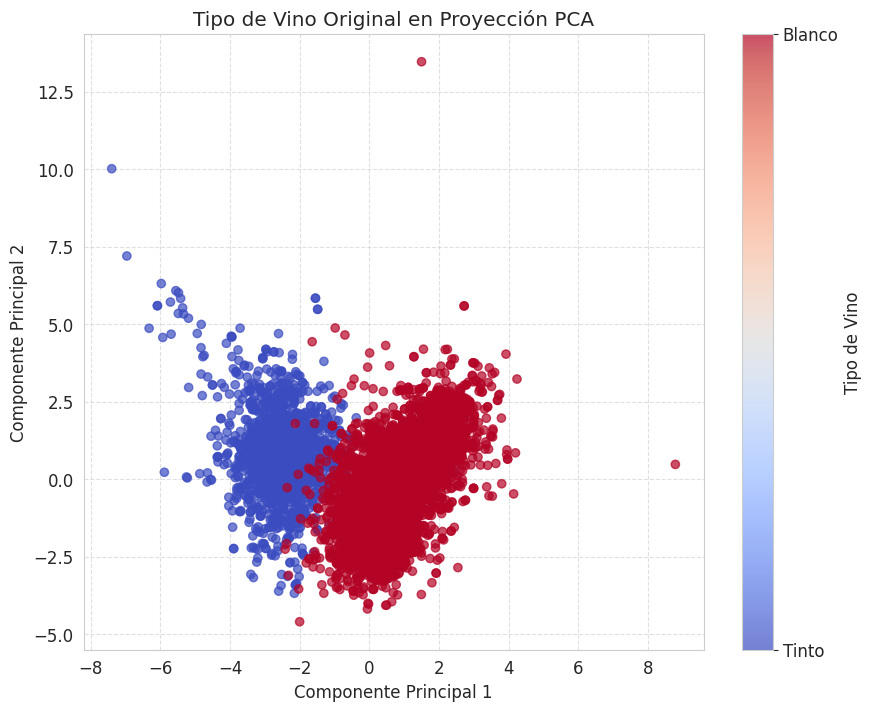

In [22]:
plt.figure(figsize=(10, 8))
scatter_original_pca = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_type, cmap='coolwarm', alpha=0.7)
plt.title('Tipo de Vino Original en Proyección PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(scatter_original_pca, ticks=[0, 1], format=plt.FuncFormatter(lambda x, p: 'Tinto' if x==0 else 'Blanco'), label='Tipo de Vino')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# (A COMPLETAR) Comenta aquí tus observaciones sobre la separación con PCA
# "PCA logra [una buena/mala] separación visual de los vinos por tipo, lo que indica..."
# "Los clusters encontrados por KMeans/DBSCAN se [alinean/no alinean] bien con la separación de PCA..."

En la proyección PCA se aprecia una separación visual clara entre vinos tintos y blancos, principalmente a lo largo del Componente Principal 1: los tintos se concentran mayormente hacia valores negativos, mientras que los blancos se ubican predominantemente hacia valores positivos. Existe solapamiento en la zona central, lo que indica que algunas observaciones comparten perfiles fisicoquímicos similares y no se separan perfectamente en 2D.

**Relación con los clusters obtenidos:**

Los clusters de KMeans (K=4) se alinean razonablemente con esta estructura: en el plano PCA se observan grupos que tienden a ocupar regiones coherentes con la separación por tipo de vino, lo cual sugiere que KMeans está capturando variaciones fisicoquímicas relacionadas con el tipo. En cambio, DBSCAN muestra un cluster dominante que mezcla gran parte de la nube y deja microclusters/ruido, por lo que su partición no refleja tan claramente la separación por tipo en esta proyección.

Cabe destacar que los dos primeros componentes explican aproximadamente 50% de la varianza, por lo que esta visualización resume buena parte de la estructura, aunque no toda; el solapamiento observado es esperable

<a name="tsne"></a>
### 5.3. Técnica de Reducción 2: t-SNE para Visualización
t-SNE (t-Distributed Stochastic Neighbor Embedding) es una técnica no lineal que se enfoca en preservar las relaciones de proximidad local, lo que la hace excelente para visualizar agrupamientos (clusters).

#### TAREAS EN EL NOTEBOOK:
1.  **Paso 1: Aplicar t-SNE.**
    * Inicializar `TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)`.
    * Entrenar y transformar `X_scaled` usando `.fit_transform()`. Guardar en `X_tsne`. (¡Este paso puede tardar varios segundos/minutos!).

In [23]:
print("Ejecutando t-SNE... (esto puede tomar un tiempo considerable)")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_scaled)

print(f"Forma de los datos después de t-SNE: {X_tsne.shape}")

Ejecutando t-SNE... (esto puede tomar un tiempo considerable)


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Forma de los datos después de t-SNE: (6497, 2)


2.  **Paso 2: Visualizar Clusters de KMeans en t-SNE.**
    * Crear un `scatter plot` de `X_tsne` coloreado por `clusters_kmeans`.
    * Añadir título, etiquetas de ejes y una barra de color.

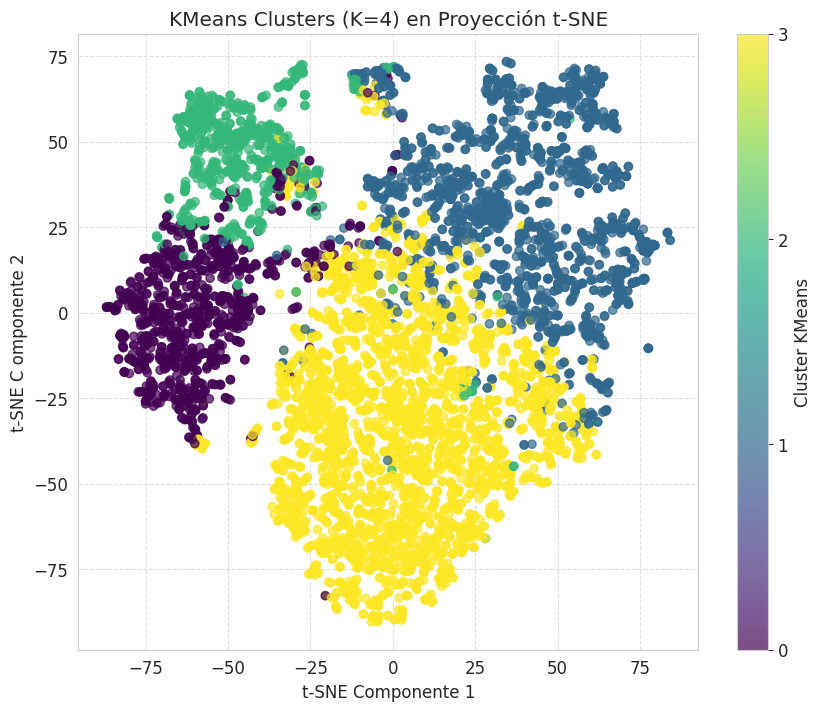

In [24]:
if 'clusters_kmeans' in locals():
    plt.figure(figsize=(10, 8))
    scatter_kmeans_tsne = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=clusters_kmeans, cmap='viridis', alpha=0.7)
    plt.title(f'KMeans Clusters (K={k_elegido}) en Proyección t-SNE')
    plt.xlabel('t-SNE Componente 1')
    plt.ylabel('t-SNE C omponente 2')
    plt.colorbar(scatter_kmeans_tsne, label='Cluster KMeans', ticks=range(k_elegido))
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()
else:
    print("Por favor, ejecuta la sección de KMeans para obtener 'clusters_kmeans'.")

Los clusters de KMeans se ven como regiones relativamente coherentes en t-SNE, aunque persisten zonas de transición (solapamiento), consistente con el Silhouette bajo–moderado obtenido

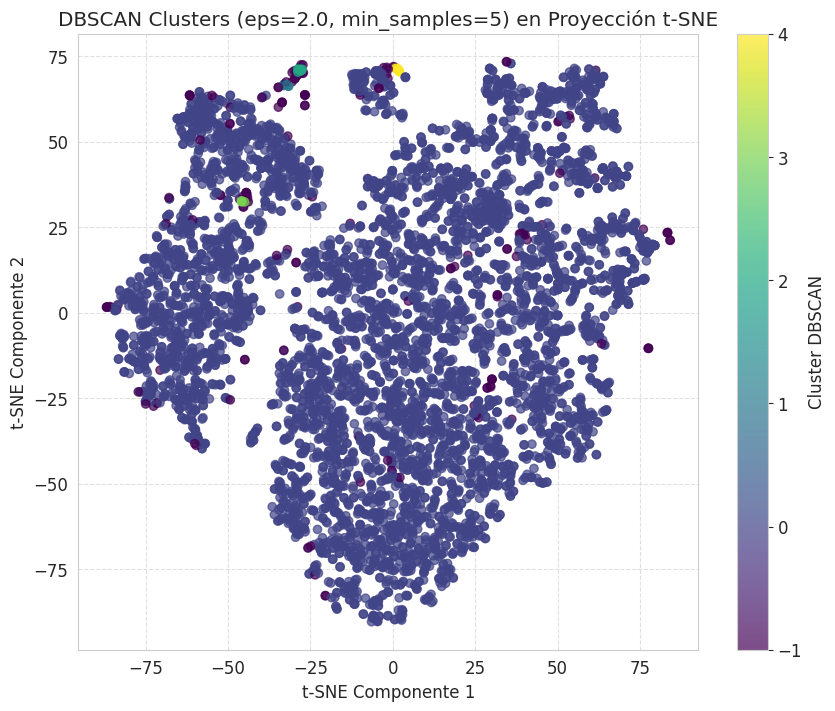

In [25]:
if 'clusters_dbscan' in locals():
    plt.figure(figsize=(10, 8))
    scatter_dbscan_tsne = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=clusters_dbscan, cmap='viridis', alpha=0.7)
    plt.title(f'DBSCAN Clusters (eps={eps_elegido}, min_samples={min_samples_dbscan}) en Proyección t-SNE')
    plt.xlabel('t-SNE Componente 1')
    plt.ylabel('t-SNE Componente 2')
    plt.colorbar(scatter_dbscan_tsne, label='Cluster DBSCAN')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()
else:
    print("Por favor, ejecuta la sección de DBSCAN para obtener 'clusters_dbscan'.")

DBSCAN sigue mostrando un cluster dominante y algunos subgrupos pequeños/ruido. Esto refuerza que el dataset presenta una gran región densa principal y que DBSCAN, con estos parámetros, actúa más como detector de outliers que como segmentador balanceado

4.  **Paso 4: Comparación con Tipo de Vino Original.**
    * Crear un `scatter plot` de `X_tsne` coloreado por `y_type`.
    * Añadir título, etiquetas de ejes y una barra de color interpretativa.
    * Comentar las observaciones sobre la separación y la preservación local.

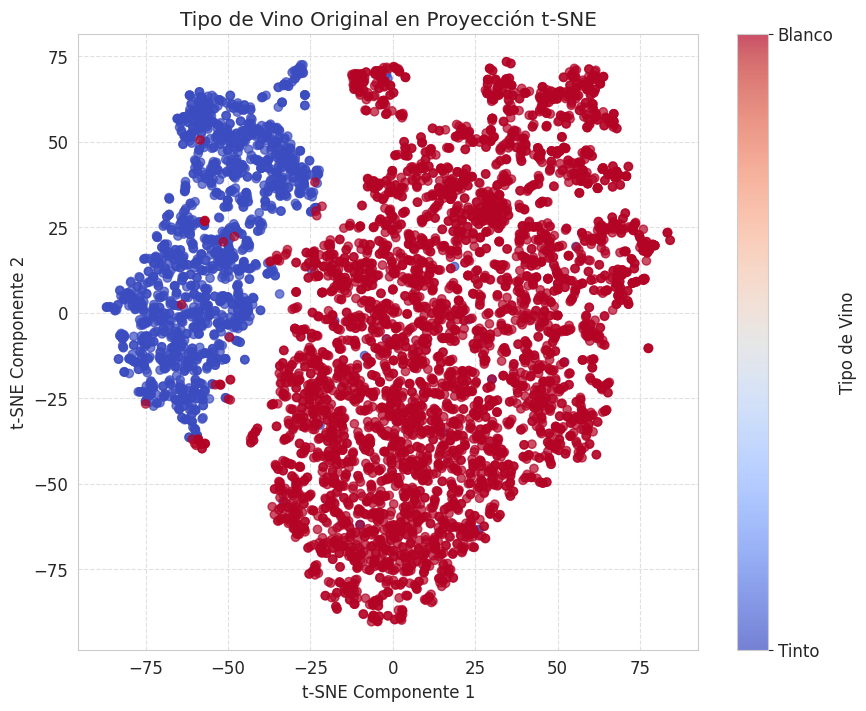

In [26]:
plt.figure(figsize=(10, 8))
scatter_original_tsne = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_type, cmap='coolwarm', alpha=0.7)
plt.title('Tipo de Vino Original en Proyección t-SNE')
plt.xlabel('t-SNE Componente 1')
plt.ylabel('t-SNE Componente 2')
plt.colorbar(scatter_original_tsne, ticks=[0, 1], format=plt.FuncFormatter(lambda x, p: 'Tinto' if x==0 else 'Blanco'), label='Tipo de Vino')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# (A COMPLETAR) Comenta aquí tus observaciones sobre la separación con t-SNE
# "t-SNE logra [una mejor/peor] separación visual de los clusters/tipos de vino en comparación con PCA, lo que sugiere..."
# "Observamos que t-SNE tiende a formar agrupaciones más densas para los clusters..."

La separación por tipo de vino (tinto/blanco) se aprecia claramente también en t-SNE, confirmando que una parte importante de la estructura del espacio fisicoquímico está asociada al tipo de vino

t-SNE logra una **mejor separación visual** de los tipos de vino en comparación con PCA. En la proyección se distinguen dos regiones claramente diferenciadas, lo que sugiere que, en el espacio original, las diferencias fisicoquímicas asociadas al tipo (tinto/blanco) generan **estructuras no lineales** que t-SNE preserva mejor a nivel local.

Además, se observa que t-SNE tiende a formar **agrupaciones más densas y compactas**, haciendo más evidentes “islas” o subgrupos. En este contexto, los clusters de **KMeans (K=4)** aparecen como regiones relativamente coherentes con cierta transición en los bordes, mientras que **DBSCAN** vuelve a concentrar la mayor parte de los puntos en un **cluster dominante** y deja algunos microclusters/ruido, reforzando que aquí DBSCAN funciona mejor como detector de outliers/subgrupos pequeños que como segmentador global balanceado.



<a name="umap"></a>
### 5.4. Técnica de Reducción 3: UMAP para Visualización
UMAP (Uniform Manifold Approximation and Projection) es una técnica de reducción de dimensionalidad no lineal más reciente y a menudo más rápida que t-SNE, que busca un balance entre la preservación de la estructura local y global.

#### TAREAS EN EL NOTEBOOK:
1.  **Paso 1: Aplicar UMAP.**
    * Inicializar `umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)` (puedes ajustar `n_neighbors` y `min_dist`).
    * Entrenar y transformar `X_scaled` usando `.fit_transform()`. Guardar en `X_umap`.

In [27]:
print("Ejecutando UMAP... (generalmente más rápido que t-SNE)")
reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1) # Ajusta parámetros si es necesario
X_umap = reducer.fit_transform(X_scaled)

print(f"Forma de los datos después de UMAP: {X_umap.shape}")

Ejecutando UMAP... (generalmente más rápido que t-SNE)


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Forma de los datos después de UMAP: (6497, 2)


UMAP reduce de 11 variables a 2 dimensiones para poder visualizar.

A diferencia de PCA (lineal), UMAP es no lineal: intenta que los puntos que eran “vecinos” en el espacio original sigan quedando cerca en 2D, pero también mantiene cierto orden global.

2.  **Paso 2: Visualizar Clusters de KMeans en UMAP.**
    * Crear un `scatter plot` de `X_umap` coloreado por `clusters_kmeans`.
    * Añadir título, etiquetas de ejes y una barra de color.

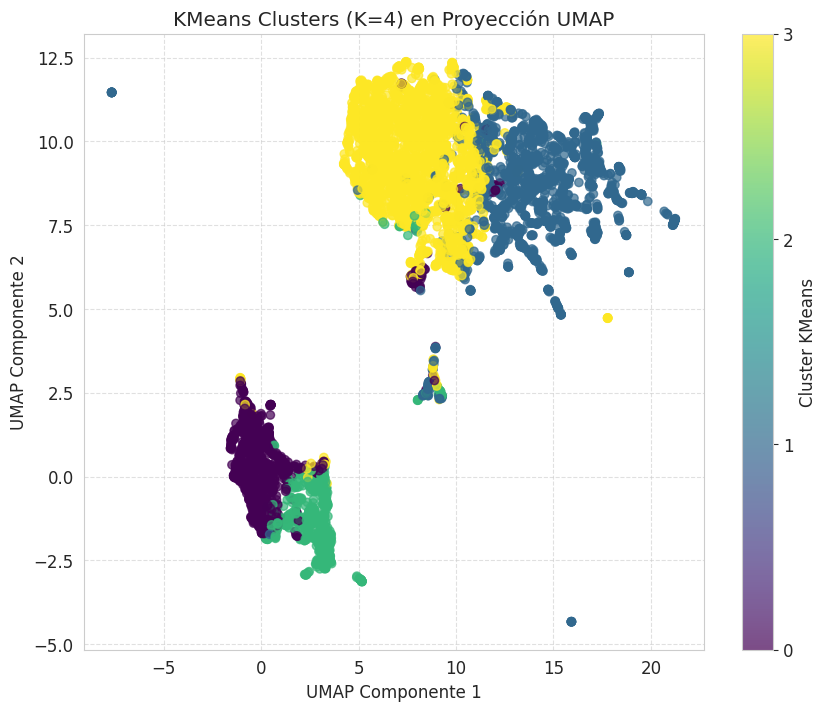

In [28]:
if 'clusters_kmeans' in locals():
    plt.figure(figsize=(10, 8))
    scatter_kmeans_umap = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=clusters_kmeans, cmap='viridis', alpha=0.7)
    plt.title(f'KMeans Clusters (K={k_elegido}) en Proyección UMAP')
    plt.xlabel('UMAP Componente 1')
    plt.ylabel('UMAP Componente 2')
    plt.colorbar(scatter_kmeans_umap, label='Cluster KMeans', ticks=range(k_elegido))
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()
else:
    print("Por favor, ejecuta la sección de KMeans para obtener 'clusters_kmeans'.")

En la proyección UMAP, los clusters de KMeans (K=4) aparecen como regiones bien diferenciadas, con una separación visual más marcada que en PCA. Se observa un gran grupo en la zona superior derecha y otro conjunto de puntos en la zona inferior izquierda, donde KMeans subdivide ese bloque en dos clusters cercanos. También aparecen pequeños “islotes” o subgrupos aislados, lo cual sugiere la presencia de observaciones con perfiles fisicoquímicos particulares.

Esta visualización indica que, en el espacio no lineal de UMAP, existen agrupamientos naturales bastante definidos. Por ello, KMeans resulta interpretable para segmentar el dataset en perfiles fisicoquímicos predominantes, aunque puede existir alguna transición o solapamiento en las fronteras entre clusters.


3.  **Paso 3: Visualizar Clusters de DBSCAN en UMAP.**
    * Crear un `scatter plot` de `X_umap` coloreado por `clusters_dbscan`.
    * Añadir título, etiquetas de ejes y una barra de color.

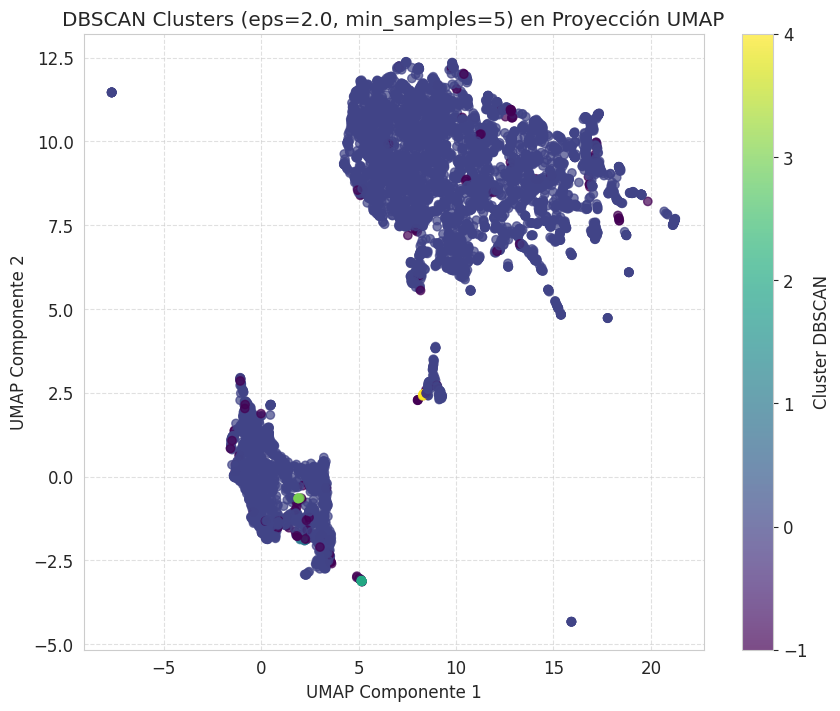

In [29]:
if 'clusters_dbscan' in locals():
    plt.figure(figsize=(10, 8))
    scatter_dbscan_umap = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=clusters_dbscan, cmap='viridis', alpha=0.7)
    plt.title(f'DBSCAN Clusters (eps={eps_elegido}, min_samples={min_samples_dbscan}) en Proyección UMAP')
    plt.xlabel('UMAP Componente 1')
    plt.ylabel('UMAP Componente 2')
    plt.colorbar(scatter_dbscan_umap, label='Cluster DBSCAN')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()
else:
    print("Por favor, ejecuta la sección de DBSCAN para obtener 'clusters_dbscan'.")

En la proyección UMAP se observa que DBSCAN asigna la gran mayoría de los puntos a un único cluster dominante (cluster 0), mientras que solo identifica unos pocos microclusters y algunos puntos como ruido (−1), ubicados mayormente en zonas periféricas o aisladas del embedding.

Esto indica que, con eps = 2.0 y min_samples = 5, el conjunto presenta una región de densidad muy amplia y DBSCAN no encuentra múltiples regiones densas grandes claramente separadas. En consecuencia, en esta configuración DBSCAN se comporta más como un detector de outliers/subgrupos pequeños que como un segmentador global “balanceado” del dataset.


4.  **Paso 4: Comparación con Tipo de Vino Original.**
    * Crear un `scatter plot` de `X_umap` coloreado por `y_type`.
    * Añadir título, etiquetas de ejes y una barra de color interpretativa.
    * Comentar las observaciones sobre la separación, velocidad y preservación global/local.

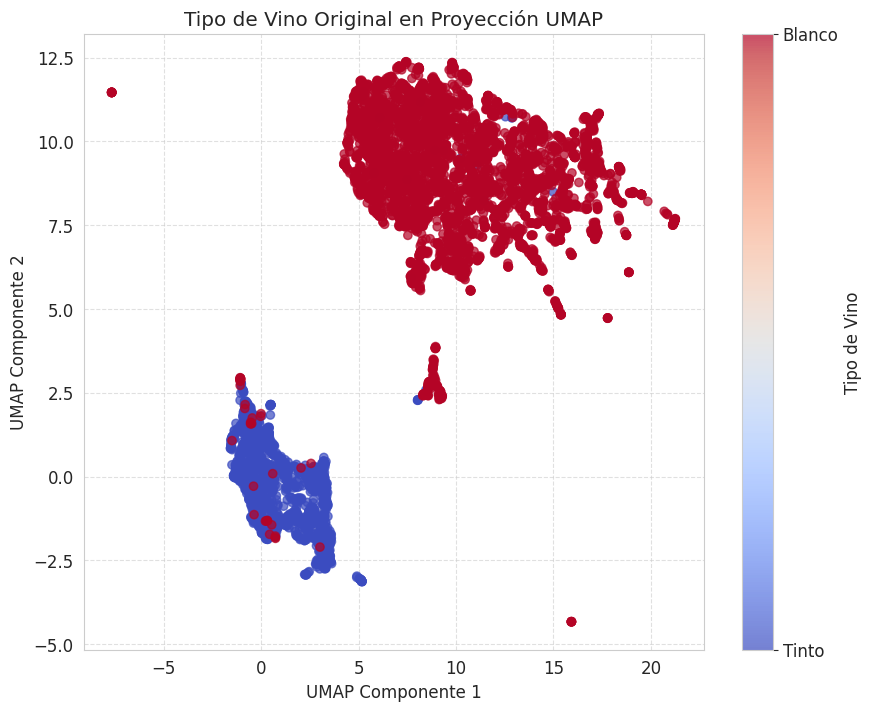

In [30]:
plt.figure(figsize=(10, 8))
scatter_original_umap = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y_type, cmap='coolwarm', alpha=0.7)
plt.title('Tipo de Vino Original en Proyección UMAP')
plt.xlabel('UMAP Componente 1')
plt.ylabel('UMAP Componente 2')
plt.colorbar(scatter_original_umap, ticks=[0, 1], format=plt.FuncFormatter(lambda x, p: 'Tinto' if x==0 else 'Blanco'), label='Tipo de Vino')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# (A COMPLETAR) Comenta aquí tus observaciones sobre la separación con UMAP
# "UMAP parece ofrecer [una excelente/buena/regular] visualización, con clusters [más compactos/más dispersos] y [mejor/peor] preservación de la estructura global..."
# "La separación de los tipos de vino original con UMAP es..."


En la proyección UMAP se aprecia una separación muy marcada entre los vinos tintos y blancos. Los tintos se concentran principalmente en la región inferior–izquierda, mientras que los blancos se agrupan en la región superior–derecha, con muy poco solapamiento entre ambos.

Esto sugiere que existe una señal fisicoquímica fuerte asociada al tipo de vino y que UMAP la representa de forma muy nítida en 2D, preservando bien vecindades locales y mostrando una separación global clara entre las dos clases.


**(A COMPLETAR) Observaciones sobre la separación con UMAP:**
UMAP parece ofrecer una excelente visualización: se observan grupos más compactos y una separación más clara que con PCA, manteniendo además un buen equilibrio entre preservación local (puntos vecinos siguen cerca) y estructura global (los grandes grupos quedan bien separados). En términos prácticos, resulta una alternativa rápida y muy efectiva para visualizar la estructura del dataset.

La separación de los tipos de vino original con UMAP es muy clara: se distinguen dos regiones principales que corresponden a tinto y blanco, con mínimo solapamiento. Esto refuerza que el tipo de vino es un factor dominante en la estructura de los datos y explica por qué las técnicas de clustering tienden a reflejar, al menos parcialmente, esa diferenciación.


<a name="conclusion_reduccion"></a>
### 5.5. (A COMPLETAR) Tareas Finales de Reducción y Conclusión
Una vez generadas todas las proyecciones visuales, es momento de analizar cuál método nos ofrece la visión más clara, perspicaz y útil de la estructura de nuestros datos y de los clusters encontrados.

#### TAREAS EN EL NOTEBOOK:
1.  **Comparación Visual Exhaustiva:**
    * Vuelvan a revisar todos los gráficos de PCA, t-SNE y UMAP (con clusters de KMeans, DBSCAN y el tipo de vino original).
    * ¿Cuál proyección muestra la mejor separación entre los clusters encontrados por KMeans y DBSCAN?
    * ¿Cuál preserva mejor la separación natural entre vinos tintos y blancos?
    * ¿Observan alguna estructura interesante (sub-grupos, outliers, continuidad) en alguna de las visualizaciones que no era evidente antes?

Al comparar las proyecciones PCA, t-SNE y UMAP, se observa que UMAP (y de forma similar t-SNE) ofrece la mejor separación visual de los clusters de KMeans, mostrando grupos más compactos y fronteras más claras que PCA, donde se aprecia mayor solapamiento por tratarse de una reducción lineal en 2D.

En cuanto a la separación natural tinto vs. blanco, las tres técnicas la reflejan, pero UMAP/t-SNE la muestran de manera más nítida, con menor solapamiento. Respecto a DBSCAN, en todas las proyecciones se mantiene un patrón consistente: un cluster dominante, presencia de microclusters y algunos outliers (ruido, -1), lo que sugiere que con los parámetros actuales DBSCAN es más útil para detectar atípicos/subgrupos pequeños que para una segmentación global balanceada.

Finalmente, en UMAP/t-SNE se distinguen con mayor claridad subgrupos aislados (“islotes”) y observaciones periféricas, estructuras que resultan menos evidentes en PCA.

```
(A COMPLETAR) Compara aquí las visualizaciones y la separación de clusters/tipos de vino:

"Al comparar las proyecciones de PCA, t-SNE y UMAP, se observa que [t-SNE/UMAP/PCA] es el que mejor logra visualizar la separación de los clusters de [KMeans/DBSCAN], mientras que [otro método] es mejor para el tipo de vino original porque..."

"Algunas estructuras interesantes observadas son..."
```
Al comparar las proyecciones de PCA, t-SNE y UMAP, se observa que UMAP es el método que mejor logra visualizar la separación de los clusters de KMeans, ya que muestra agrupamientos más compactos y regiones más claramente delimitadas. Para el tipo de vino original (tinto/blanco), UMAP y t-SNE evidencian una separación más nítida que PCA, mientras que PCA resulta útil como referencia por su interpretación lineal, aunque con mayor solapamiento.

Algunas estructuras interesantes observadas son la presencia de subgrupos aislados (“islotes”), zonas de transición entre regiones y puntos periféricos que pueden interpretarse como outliers, especialmente visibles en UMAP/t-SNE.

2.  **Consideraciones de Rendimiento:**
    * Comenten brevemente sobre el tiempo de ejecución aproximado de cada método de reducción de dimensionalidad (PCA es rápido, t-SNE es lento, UMAP intermedio).

En términos de rendimiento computacional, PCA fue el método más rápido (ejecución casi inmediata), ya que es una técnica lineal y eficiente. t-SNE fue el más lento, debido a su naturaleza no lineal y al costo de preservar relaciones locales en el espacio reducido. UMAP mostró un desempeño intermedio (generalmente más rápido que t-SNE), manteniendo un buen balance entre velocidad y calidad de visualización para este tamaño de dataset.

```
(A COMPLETAR) Comentarios sobre el rendimiento:

"En términos de velocidad, PCA fue el más rápido, seguido por UMAP. t-SNE fue el más lento, lo cual es de esperar para datasets de este tamaño."
```

En términos de velocidad, PCA fue el más rápido, seguido por UMAP. t-SNE fue el más lento, lo cual es esperable para un dataset de este tamaño debido a su mayor costo computacional en la optimización de la proyección no lineal.

3.  **Justificar:**
    * Escriban una conclusión clara: ¿Qué técnica de reducción de dimensionalidad (PCA, t-SNE o UMAP) consideran más efectiva para **visualizar** la estructura de este dataset de vinos en particular, y por qué?
    * Argumenten su elección basándose en la claridad de los clusters, la preservación de la estructura original y la eficiencia computacional.

Considero que UMAP es la técnica más efectiva para visualizar la estructura de este dataset de vinos.

- Claridad de clusters: en las proyecciones UMAP se observa una separación más nítida de las regiones y una visualización más “ordenada” de los grupos que en PCA, y comparable (o más limpia) que t-SNE.

- Preservación de la estructura original: UMAP mantiene bien la estructura local (vecindades) sin perder completamente la separación global, lo que facilita interpretar tanto agrupamientos como transiciones entre grupos.

- Eficiencia computacional: ofrece un buen balance entre calidad visual y tiempo de ejecución: es mucho más rápido que t-SNE y, aunque PCA es el más veloz, UMAP brinda una representación más informativa en este caso.


En síntesis, UMAP combina mejor interpretabilidad visual, preservación de estructura y rendimiento para este problema.

```
(A COMPLETAR) Mi Conclusión sobre la Mejor Técnica de Reducción de Dimensionalidad para Visualización:

Basado en [la claridad visual, la preservación de estructuras y el rendimiento], considero que [PCA / t-SNE / UMAP] es la técnica más efectiva para visualizar este dataset porque...

```

Basado en la claridad visual, la preservación de estructuras y el rendimiento, considero que UMAP es la técnica más efectiva para visualizar este dataset porque logra una separación más nítida de los grupos (incluyendo la distinción natural entre vinos tintos y blancos), mantiene un buen equilibrio entre estructura local y global, y además ofrece una eficiencia computacional superior a t-SNE (con resultados visuales más informativos que PCA para este caso)

<a name="final"></a>
# 6. Conclusiones: A COMPLETAR Conclusiones Finales del Proyecto
En esta sección final, resume tus hallazgos clave de todo el proyecto integrador del Módulo 3. ¡Es tu oportunidad para mostrar todo lo que aprendiste!

#### TAREAS EN EL NOTEBOOK:

1.  **Resumen de Hallazgos Clave:**
    * ¿Qué descubriste sobre la estructura intrínseca de los datos de vino a través del clustering?
    * ¿Cómo te ayudaron las técnicas de reducción de dimensionalidad a entender mejor estas estructuras? ¿Hubo alguna visualización que te sorprendiera o te diera una nueva perspectiva?
    * ¿Consideras que los clusters encontrados se correlacionan con características significativas del vino (ej. tipo, calidad, otros perfiles no obvios)?

2.  **Desafíos y Aprendizajes:**
    * ¿Cuáles fueron los principales desafíos al trabajar con modelos no supervisados y reducción de dimensionalidad en este dataset?
    * ¿Qué nuevos aprendizajes clave te llevas de este módulo y este proyecto?

3.  **Aplicaciones Futuras:**
    * ¿Cómo crees que estas técnicas no supervisadas podrían aplicarse en escenarios reales de la industria del vino o en otros dominios? (ej. segmentación de clientes, detección de anomalías, descubrimiento de nuevas categorías de productos).


A lo largo del proyecto, lo principal que observé es que el dataset sí tiene una estructura interna, pero no aparecen clusters “perfectos” o totalmente separados. Con KMeans (K=4) pude obtener una segmentación más estable y fácil de explicar, y además el Silhouette fue un poco mejor que en DBSCAN (0.248 vs 0.212). En cambio, DBSCAN me resultó menos útil como segmentación general, porque con los parámetros probados tendía a formar un cluster dominante y varios grupos muy chicos, y parte de los datos quedaban como ruido. De todos modos, DBSCAN me parece interesante como complemento, sobre todo para detectar outliers o subgrupos densos pequeños.

Las técnicas de reducción de dimensionalidad me ayudaron bastante a entender lo que estaba pasando, porque con 11 variables es difícil imaginar la forma del dataset. PCA fue útil para tener una vista general, pero como solo explica aproximadamente el 50% de la varianza con 2 componentes, se nota que la proyección no muestra toda la estructura. Con t-SNE y, sobre todo, con UMAP, la separación se ve mucho más clara. Lo que más me llamó la atención es que el tipo de vino (tinto/blanco) aparece como una estructura muy dominante: en UMAP se ve casi como dos regiones bien marcadas, con poco solapamiento. Esto confirma que, con estas variables fisicoquímicas, la diferencia por tipo de vino es muy fuerte.

En cuanto a la relación con la calidad, no vi una separación tan evidente como con el tipo de vino. Es decir, los clusters parecen asociarse más a perfiles fisicoquímicos generales (y al tipo de vino) que a niveles de calidad “limpios” o bien separados. Probablemente la calidad depende de combinaciones más sutiles de variables y no se agrupa tan fácilmente sin supervisión.

El desafío principal, para mí, fue que en aprendizaje no supervisado no hay una respuesta única “correcta”: tuve que justificar las decisiones con el método del codo, métricas internas (Silhouette, Calinski–Harabasz y Davies–Bouldin) y después validar con visualizaciones. También noté que DBSCAN es muy sensible a eps y min_samples: pequeños cambios alteran mucho el número de clusters y el ruido, por eso fue importante probar varias configuraciones y comparar.

Como aprendizaje me llevo que estas técnicas sirven mucho para explorar datos y encontrar patrones antes de modelar en forma supervisada. En un contexto real, esto podría aplicarse para segmentar vinos por perfil fisicoquímico, detectar lotes atípicos (anomalías), o incluso para clasificar productos por “familias” similares. Y fuera del dominio del vino, lo mismo se puede usar para segmentación de clientes, detección de comportamientos raros o análisis exploratorio en cualquier dataset con muchas variables.

```
(A COMPLETAR) Tus Conclusiones Finales Aquí:

"Este proyecto integrador nos permitió adentrarnos en el mundo del aprendizaje no supervisado, revelando patrones y estructuras ocultas en el dataset de vinos que no serían evidentes con un análisis supervisado tradicional..."

```

Este proyecto me ayudó a entender el aprendizaje no supervisado aplicándolo al dataset de vinos. Con el clustering vi que hay grupos con cierta estructura, aunque no quedan totalmente separados, y que el tipo de vino (tinto/blanco) influye mucho en cómo se organizan los datos. KMeans me resultó más claro para segmentar, y DBSCAN más útil para detectar outliers y subgrupos chicos.

Con PCA, t-SNE y UMAP pude “ver” mejor esos patrones; PCA dio una vista general rápida, y UMAP fue el que mostró la separación más clara. En resumen, aprendí que en no supervisado hay que justificar con métricas + gráficos, y que estas técnicas sirven para segmentar y detectar anomalías en casos reales.